# Summary

真融宝（印尼） 数据说明：

测试产品是黑名单。

样本数据说明：

1) 本次共测试2000个不同三要素(手机号 + 姓名 + ID 号码)，样本数据类型是  被规则拒绝 + 放款成功；

2) 放款成功样本共计 1500 个，放款时间2019-12/20--2019/12/26，其中首次7+ 的有494个，占比32.9%

结论：
1) 在成功放款的样本上：

命中黑名单的逾期率是72.6%, 命中率为4.9%，单变量iv= 0.09；

2）在黑名单拒绝的样本上：

和本地规则的重合度为：7.6%

--因为该变量有区分度且和本地的规则重合度较低，建议接入，放在三方黑名单节点使用。



用最新的v5阈值看模型节点是否通过：

放款成功样本共计 503 个，其中首次7+ 的有114个，占比22.7%

结论：

1）在成功放款的样本上：

命中黑名单的逾期率是72.7%, 命中率为2.2%，单变量iv= 0.06；

2）在黑名单拒绝的样本上：

和本地规则的重合度为：7.9%

--因为该变量有区分度且和本地的规则重合度较低，建议接入，放在三方黑名单节点使用。




# packages

In [26]:
import sys
import os
import datetime
import time
import pandas as pd
import numpy as np
import re
pd.options.display.latex.repr = True
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.rcParams['font.sans-serif'] = ['STFangsong']
plt.rcParams['font.family']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.pylab as mpl
plt.rc('figure', figsize=(5, 3))
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import database_conncet as data_con
import data_processing as dp
import data_encryption as de
from data_io_utils import *
import plot_tools as pt
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = '/Users/yantingting/Seafile/风控/模型/10 印尼/三方数据/06 真融宝/'

# 数据拼接和标签提取

In [50]:
result= pd.read_csv(os.path.join(file_path, '真融宝测试结果.csv'))
df1 = pd.read_excel(os.path.join(file_path, '真融宝样本.xlsx'),usecols=['id', 'loan_id'])
result = result.merge(df1, on = 'id', how = 'left')
rule = pd.read_csv(os.path.join(file_path,'规则拒绝.csv'))
fangkuan = pd.read_csv(os.path.join(file_path,'放款.csv'))
df2 = rule.append(fangkuan)
df2['test_type'] = df2['loan_status'].apply(lambda x: 'rule_reject' if x == 'DENIED' else 'fund')
df = result.merge(df2[['loan_id', 'test_type']], on = 'loan_id', how = 'left')
save_data_to_pickle(df,file_path,'真融宝测试结果.pkl')
df.head(2)


,id,apply_time,id_card_name,md5_cell_phone,md5_id_card_no,is_hit,loan_id,test_type
0,1,2019/12/23 11:29,Yudit tiawati,718541a76754da4741d300c2046a7af9,c221bf6a568695091653ad2a9f7c711c,0,415847439416074240,fund
1,2,2019/12/24 12:04,Fatimah Hanum,4c2203d7348f007da4d592175a71b9d3,ecd6bbfa276862603b27a82a3af57182,0,416218642613960704,fund


In [51]:
query1 = '''
select
    loan_id,
	effective_date,
	return_flag,
	case when late_date-effective_date = approved_period then 1 else 0 end as dpd1,
	case when DPD >= 3 then  1 else 0 end as dpd3,
	case when DPD >= 7 then 1 else 0 end as dpd7
from
	(
	select
		t1.id loan_id,
		effective_date,
		return_flag,
		loan_status,
		approved_period,
		late_date,
		approved_principal,
		case
			when loan_status = 'COLLECTION' then current_date-late_date
			else round(late_fee /(approved_principal*0.025))::int end as DPD
		from
			(
			select
				*
			from
				dw_gocash_go_cash_loan_gocash_core_loan
			where
				return_flag = 'false'
	            and effective_date >= '2019-10-01'
	            and apply_time::date between '2019-12-20' and '2019-12-25') t1
		left join (
			select
				*
			from
				(
				select
					order_id,
					late_date,
					row_number() over(partition by order_id
				order by
					late_date asc) as num
				from
					dw_gocash_gocash_collection_col_case
				where
					(order_status = 'COLLECTION_PAIDOFF'
					or order_status = 'COLLECTION')
					and app_id not in ('Credits',
					'KASANDAAI'))t
			where
				num = 1) t2 on
			t1.id = t2.order_id
			left join (
				select
					id,
					media_source
				from
					public.dw_gocash_go_cash_loan_gocash_core_customer
				) t3 on
			t1.customer_id = t3.id)t

'''

In [52]:
df_flag = data_con.database_gn(query1)
df_all = df.merge(df_flag, on = 'loan_id',how='left')
save_data_to_pickle(df_all, file_path, 'df_flag.pkl')

Successful connection


# 分析

In [31]:
df_all = load_data_from_pickle(file_path,'df_flag.pkl')
df_rule = df_all[df_all['test_type'] =='rule_reject']
df_fund = df_all[df_all['test_type'] =='fund']

In [32]:
frame1 = pd.pivot_table(df_rule, index = 'is_hit',values= 'loan_id', aggfunc='count')
frame1['rate'] = frame1['loan_id']/frame1['loan_id'].sum()
frame1

,loan_id,rate
is_hit,,
0,462,0.924
1,38,0.076


,group,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
0,is_hit,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
1,0,1427,441,986,0.951333,0.30904,0.892713,0.980119,0.0874067,0.30904,-0.0934096,0.00816463
2,1,73,53,20,0.0486667,0.726027,1,1,0,0.329333,1.68576,0.147347


black1_iv: 0.08740673368694707


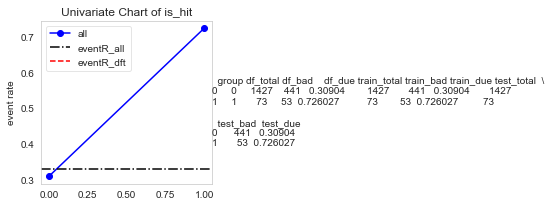

In [33]:
black1 = dp.ContinuousBin(data_set = df_fund, col='is_hit', target = 'dpd7', n = 10, special_attribute=[-1,np.nan], method='equal freq')[0]
black1
black1_iv = dp.ContinuousBin(data_set = df_fund, col='is_hit', target = 'dpd7', n = 10, special_attribute=[-1,np.nan], method='equal freq')[1]
print('black1_iv: %s'%black1_iv)
pt.univariate_chart(df = df_fund, col = 'is_hit', target = 'dpd7', n = 10,
                     special_attribute = [-1,np.nan],
                     dftrain=df_fund, dftest=df_fund,
                     draw_all=True, draw_train_test=False, result_path=None)

In [34]:
df_fund.head()

,id,apply_time,id_card_name,md5_cell_phone,md5_id_card_no,is_hit,loan_id,test_type,effective_date,return_flag,dpd1,dpd3,dpd7
0,1,2019/12/23 11:29,Yudit tiawati,718541a76754da4741d300c2046a7af9,c221bf6a568695091653ad2a9f7c711c,0,415847439416074240,fund,2019-12-23,false,1.0,1.0,1.0
1,2,2019/12/24 12:04,Fatimah Hanum,4c2203d7348f007da4d592175a71b9d3,ecd6bbfa276862603b27a82a3af57182,0,416218642613960704,fund,2019-12-24,false,0.0,0.0,0.0
2,3,2019/12/22 14:28,istikhomah,97022f87bbaff80f90a37b65e4671639,8fb7f16d653cc7775b4980e3c6f2d6db,0,415530054637420544,fund,2019-12-22,false,0.0,0.0,0.0
3,4,2019/12/25 19:09,Yeni warti,83c69a8586574d18b516d5890c1292e5,c9c6e566fdc6a4ef68b42aecfe27374f,0,416687983033942016,fund,2019-12-26,false,1.0,1.0,1.0
4,5,2019/12/23 18:09,susi ida sanjaja,9fa29a2efa9051d1ffc9f9a513923280,3e03fc746abad279fa0d881ffd681cac,0,415948152465096704,fund,2019-12-24,false,0.0,0.0,0.0


In [35]:
v5_score= pd.read_excel(os.path.join(file_path, 'score_loan_1107_1223.xlsx'), sheet_name = 'data_scored')
remain_cols = ['loan_id','newusermodelv4score','newusermodelv4result','score']
df_v4_v5 = pd.merge(df_fund,v5_score[remain_cols],on='loan_id',how='inner')
df_v4_v5['v5_flag'] = df_v4_v5['score'].apply(lambda x: 'pass' if x>618 else 'reject')
df_v4_v5.shape

(918, 17)

In [36]:
df_fund1 = df_v4_v5[df_v4_v5['v5_flag'] =='pass']
df_rule1 = df_v4_v5[df_v4_v5['v5_flag'] =='reject']
df_rule1.drop(['newusermodelv4score','newusermodelv4result','score','v5_flag'],axis=1,inplace=True)

,group,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
0,is_hit,total,bad,good,per%,overdue,cum_bad,cum_good,KS,cum_overdue,WOE,IV
1,0,492,106,386,0.978131,0.215447,0.929825,0.992288,0.0624634,0.215447,-0.0650174,0.0040612
2,1,11,8,3,0.0218688,0.727273,1,1,0,0.22664,2.20821,0.137932


black2_iv: 0.06246335633428046


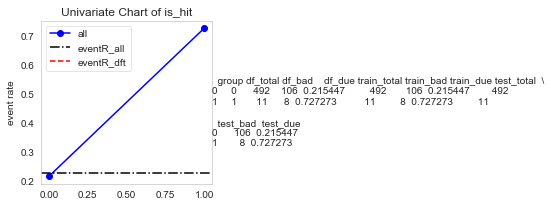

In [37]:
black2 = dp.ContinuousBin(data_set = df_fund1, col='is_hit', target = 'dpd7', n = 10, special_attribute=[-1,np.nan], method='equal freq')[0]
black2
black2_iv = dp.ContinuousBin(data_set = df_fund1, col='is_hit', target = 'dpd7', n = 10, special_attribute=[-1,np.nan], method='equal freq')[1]
print('black2_iv: %s'%black2_iv)
pt.univariate_chart(df = df_fund1, col = 'is_hit', target = 'dpd7', n = 10,
                     special_attribute = [-1,np.nan],
                     dftrain=df_fund1, dftest=df_fund1,
                     draw_all=True, draw_train_test=False, result_path=None)

In [38]:
df_rule2 = df_rule.append(df_rule1)
frame2 = pd.pivot_table(df_rule2, index = 'is_hit',values= 'loan_id', aggfunc='count')
frame2['rate'] = frame2['loan_id']/frame2['loan_id'].sum()
frame2

,loan_id,rate
is_hit,,
0,843,0.921311
1,72,0.078689
